In [6]:
from pathlib import Path
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image
from Helper import *
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import IO
from torchvision import transforms
from torch.utils.data import DataLoader

from Model import FlyingChairsDataset


In [7]:
# Cell: Training setup
import torch
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

root = r"E:\datasets\FlyingChairs_release"
batch_size = 20

# Create datasets
train_dataset = FlyingChairsDataset(root=root, split="train", transform=transform)
val_dataset = FlyingChairsDataset(root=root, split="val", transform=transform)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Using device: cuda
Train samples: 22232
Val samples: 640


In [ ]:
# Cell: Iteration-based Training Loop
from Model import FlowNet, MultiScaleEPE
import time

# Initialize model
model = FlowNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = MultiScaleEPE(weights=(1.0, 0.5, 0.25, 0.125))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training configuration
max_iterations = 500_000
val_interval = 100
save_interval = 1000
log_interval = 10


# Learning rate scheduler
def adjust_learning_rate(optimizer, iteration):
    if iteration >= 200000:
        num_halvings = (iteration - 200000) // 100000 + 1
        lr = 1e-4 / (2 ** num_halvings)
    else:
        lr = 1e-4

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


# Setup checkpoint directory
checkpoint_dir = Path('./checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

# Load checkpoint if exists
checkpoint = load_checkpoint_generic(checkpoint_dir, device)

# Initialize tracking variables
train_losses = []
val_losses = []
val_epes = []
iterations_log = []
start_iteration = 1

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iteration = checkpoint.get('iteration', 0) + 1
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_epes = checkpoint.get('val_epes', [])
    iterations_log = checkpoint.get('iterations_log', [])
    print(f"Resuming training from iteration {start_iteration}")
else:
    print("No checkpoint found, starting fresh training.")

best_val_loss = checkpoint.get('best_val_loss', float('inf')) if checkpoint else float('inf')
running_loss = 0.0

# Time tracking
start_time = time.time()

model.train()
print(f"\nStarting training from iteration {start_iteration} to {max_iterations:,}...")

iteration = start_iteration

# Main training loop with proper iterator
while iteration <= max_iterations:
    for img_pair, flow_gt in train_loader:
        if iteration > max_iterations:
            break

        # Move to device
        img_pair = img_pair.to(device, non_blocking=True)
        flow_gt = flow_gt.to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad()
        flow_preds = model(img_pair)

        # Compute loss
        loss, epe1, epe2, epe3, epe4 = criterion(flow_preds, flow_gt)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Adjust learning rate
        current_lr = adjust_learning_rate(optimizer, iteration)

        # Log progress
        if iteration % log_interval == 0:
            elapsed = time.time() - start_time
            avg_loss = running_loss / log_interval
            print(f"Iter {iteration:6d}/{max_iterations:6d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")
            running_loss = 0.0
            start_time = time.time()  # Reset timer

        # Validation
        if iteration % val_interval == 0:
            model.eval()
            val_loss = 0.0
            val_epe = 0.0

            with torch.no_grad():
                for img_pair_v, flow_gt_v in val_loader:
                    img_pair_v = img_pair_v.to(device)
                    flow_gt_v = flow_gt_v.to(device)

                    flow_preds_v = model(img_pair_v)

                    loss_v, epe1_v, epe2_v, epe3_v, epe4_v = criterion(flow_preds_v, flow_gt_v)
                    val_loss += loss_v.item()
                    val_epe += epe1_v.item()

            val_loss /= len(val_loader)
            val_epe /= len(val_loader)

            val_losses.append(val_loss)
            val_epes.append(val_epe)
            iterations_log.append(iteration)

            print(
                f">>> Validation at iter {iteration:6d} | Val Loss: {val_loss:.4f} | Val EPE: {val_epe:.4f} | LR: {current_lr:.6f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_epe': val_epe,
                    'lr': current_lr
                }, 'checkpoints/best_flownet_model.pth')
                print(f"✓ Saved best model (EPE: {val_epe:.4f})")

            model.train()
            start_time = time.time()  # Reset timer after validation

        # Save checkpoint periodically
        if iteration % save_interval == 0:
            save_checkpoint_generic(
                checkpoint_dir,
                iteration,
                {
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr': current_lr,
                    'best_val_loss': best_val_loss,
                    'val_losses': val_losses,
                    'val_epes': val_epes,
                    'iterations_log': iterations_log,
                    'train_losses': train_losses
                },
                max_checkpoints=5
            )

        iteration += 1

print("\n🎉 Training completed!")

Model parameters: 11,629,012
✅ Loaded checkpoint: checkpoints\checkpoint_iteration_102000.pth (iteration 102000)
Resuming training from iteration 102001

Starting training from iteration 102001 to 500,000...
Iter 102010/500000 | Loss: 1.6282 | Time: 8.35s
Iter 102020/500000 | Loss: 1.7843 | Time: 8.10s
Iter 102030/500000 | Loss: 1.6810 | Time: 7.96s
Iter 102040/500000 | Loss: 1.8312 | Time: 7.78s
Iter 102050/500000 | Loss: 1.8098 | Time: 8.08s
Iter 102060/500000 | Loss: 1.8434 | Time: 7.92s
Iter 102070/500000 | Loss: 1.8442 | Time: 8.20s
Iter 102080/500000 | Loss: 1.7731 | Time: 8.63s
Iter 102090/500000 | Loss: 1.7076 | Time: 8.28s
Iter 102100/500000 | Loss: 1.7599 | Time: 8.03s
>>> Validation at iter 102100 | Val Loss: 2.6745 | Val EPE: 2.0267 | LR: 0.000100
Iter 102110/500000 | Loss: 1.6912 | Time: 8.20s
Iter 102120/500000 | Loss: 1.8208 | Time: 8.22s
Iter 102130/500000 | Loss: 1.6523 | Time: 8.47s
Iter 102140/500000 | Loss: 1.7798 | Time: 8.19s
Iter 102150/500000 | Loss: 1.7509 | Ti

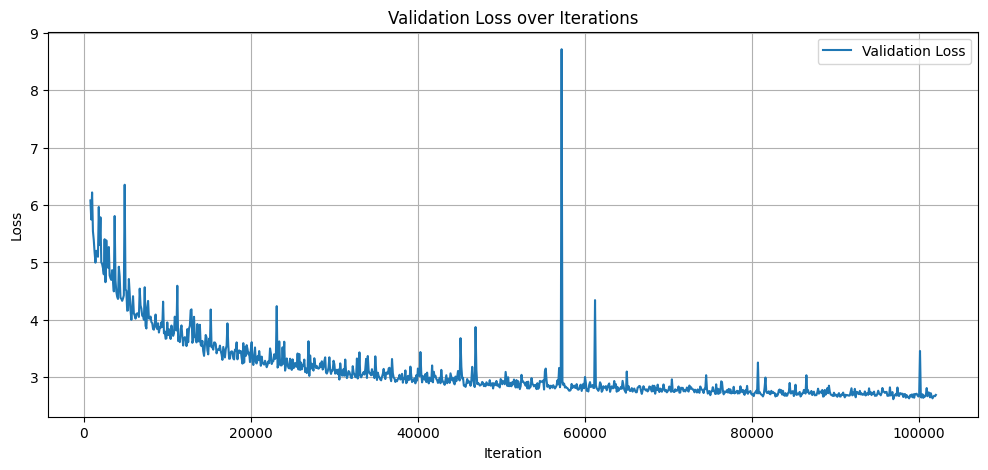

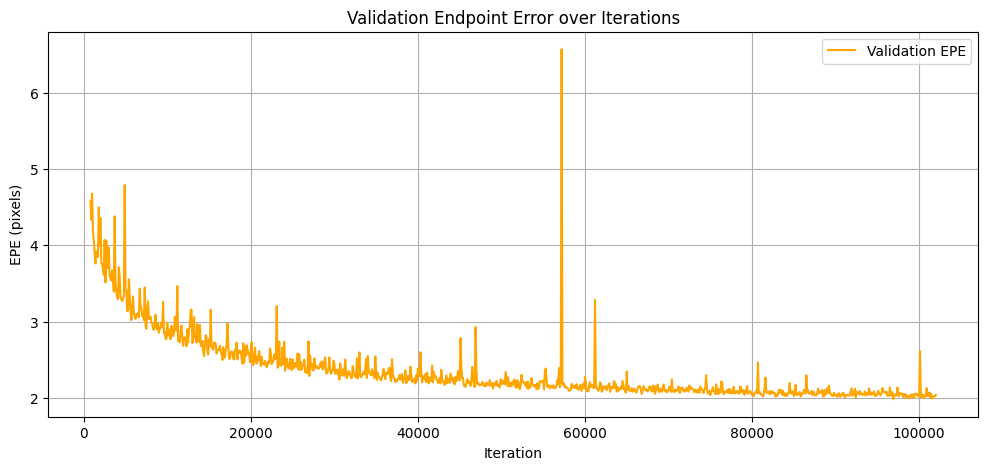

In [5]:
# Plot training curves
def plot_training_curves(iterations_log, val_losses):
    """Plot validation losses over iterations"""
    plt.figure(figsize=(12, 5))
    plt.plot(iterations_log, val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot after training
plot_training_curves(iterations_log, val_losses)

# Plot EPE over iterations
plt.figure(figsize=(12, 5))
plt.plot(iterations_log, val_epes, label='Validation EPE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('EPE (pixels)')
plt.title('Validation Endpoint Error over Iterations')
plt.legend()
plt.grid(True)
plt.show()